# Thymio project

This jupyter notebook contains all the coding and information in order to understand and run our project. The way to run the project is to have black rectangles as walls in order to design the map, bright but not reflective red and blue rectangles to use for Thymio and goal localisation repectively and a camera that is approximately 1 meter above the testing area. As long as you place all objects within the field of view of the camera, Thymio will find its way towards the goal without touching the walls dodging spontaneous 3D obstacles.

# Import Lib + connect Thymio

Here we are simply importing all the necessary libraries to run our project. The most important imports are the Kalman filter library, openCV and everything to make thymio run

In [342]:
import math
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import colors
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

%matplotlib inline

import cv2
import time

# import Thymio
import os
import sys
import time
import serial

from filterpy.kalman import KalmanFilter

# Adding the src folder in the current directory as it contains the script
# with the Thymio class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio

print(sys.executable)
th = Thymio.serial(port="\\.\COM3", refreshing_rate=0.1)

C:\Users\loicc\Anaconda3\python.exe


SerialException: could not open port '\\.\\COM3': PermissionError(13, 'Accès refusé.', None, 5)

# Function for Thymio 

Here are the functions for the Thymio actions that will be executed. 
The most interesting things here is to state that rotations of Thymio will be all 45 degrees in first approach because of our grid creation in order to have global navigation. In reality the Thymio will adjust its angles to match the grid displacement. For local navigation we chose to follow any obstacle by moving to the left and if Thymio is still stuck, it will try to move to the right of the obstacle.

In [343]:
V_case_per_second = 1.25 # vitesse by default


# Sets the direction of Thymio and defines the global rotation afterwards
def setDir(newDir):
    global dir
    
    rotate = (newDir-dir)%360
    
    if rotate < 180: turn_anticlockwise(rotate) 
    else : turn_clockwise(360-rotate)

    dir = newDir

# Computes the angle after the 2 point measurement from Thymio moving
def get_angle(point1, point2):
    
    vector = (point2[0]-point1[0], point2[1]-point1[1])
    dx = vector[0]
    dy = vector[1]

    if dy == 0:
        if dx > 0:
            angle = -90
        else:
            angle = 90
    elif dy > 0:
        angle = math.degrees(math.atan(-dx/dy))
    else:
        angle = 180 + math.degrees(math.atan(-dx/dy))
        
    return angle
    
# Aligns to move towards cell
def set_dir_cell(cell):
    global pos_est_filtered, V_case_per_second
    
    vector = (cell[0]-pos_est_filtered[0], cell[1]-pos_est_filtered[1])
    angle = get_angle(pos_est_filtered,cell)
    
    
    print(angle)
    setDir(angle)
    
    norm = np.linalg.norm(vector)
    
    return norm/V_case_per_second
    
    
# Hardcoded table to access next cell from angle
def get_deplacement(dir_to_go):
    
    if dir_to_go % 360 ==   0: dx, dy = 0,1
    if dir_to_go % 360 ==   90: dx, dy = -1,0
    if dir_to_go % 360 ==   180: dx, dy = 0,-1
    if dir_to_go % 360 ==   270: dx, dy = +1,0
    if dir_to_go % 360 ==   45: dx, dy = -1,1
    if dir_to_go % 360 ==   135: dx, dy = -1,-1
    if dir_to_go % 360 ==   225: dx, dy = 1,-1
    if dir_to_go % 360 ==   315: dx, dy = +1,1
        
    return dx,dy

# Returns the value of the cells "ahead" of the robot based on the sensor values
# return: 1 if  the cell is free, 0 if occupied
def is_forward_free():
     
    sensor_vals = th["prox.horizontal"]
    
    is_free = 1  if all(x<2000 for x in sensor_vals[1:4] ) else 0
    
    return is_free 

# return 1 if the cells in the the direction nextDir are free, based on the occupancy grid 
def is_dir_free(nextDir):
    
    
    global thymioPos, globalMap, thymioRadius
    is_free = 1
    
    dx, dy  = get_deplacement(nextDir)
        
    newPos = (thymioPos[0]+dx, thymioPos[1]+dy)
    newOccupiedCell = []
    if dx!= 0:
        for i in range(-thymioRadius, thymioRadius+1):
            newOccupiedCell.append((newPos[0] + thymioRadius*dx,newPos[1]+i ))
    if dy!= 0:
        for i in range(-thymioRadius, thymioRadius+1):
            newOccupiedCell.append((newPos[0] + i,newPos[1] + thymioRadius*dy ))

    # if the node is not in the map, skip
    if (newPos[0] + thymioRadius >= globalMap.shape[0]) or (newPos[1] + thymioRadius >= globalMap.shape[1]) or (newPos[0] - thymioRadius < 0) or (newPos[1] - thymioRadius < 0):
        return 0

    # if a cell is occupied, skip
    for cell in newOccupiedCell:
        if (globalMap[cell[0], cell[1]]):
            return 0
            
            
    return is_free

# Returns the value of the cell to the "right" of the robot based on the sensor values. 
# Returns 1 if the cell is free, 0 if occupied
def is_right_free():
    
    sensor_vals = th["prox.horizontal"]
    
    is_free = 1  if sensor_vals[4]<500 else 0
    return is_free 

# Returns the value of the cell to the "left" of the robot based on the sensor values. 
# Returns 1 if the cell is free, 0 if occupied
def is_left_free():
    
    sensor_vals = th["prox.horizontal"]
    
    is_free = 1  if sensor_vals[0]<500 else 0
    return is_free 

# Simple forward moving function
# used for global navigation
def move_forward():
    th.set_var("motor.left.target", 100)
    th.set_var("motor.right.target",100)

# Thymio moves forward, since it can go diagonally, we compensate the moving time because of the added path length
# used for local navigation
def go_forward():
    
    global dir, thymioPos, thymioRadius
    
    if dir % 90 != 0:
        ratio = 1.414
    else:
        ratio = 1

    dx,dy = get_deplacement(dir)
    thymioPos = (thymioPos[0] + dx, thymioPos[1] + dy)
        
    th.set_var("motor.left.target", 70)
    th.set_var("motor.right.target",70)
    time.sleep(ratio/V_case_per_second)
    th.set_var("motor.left.target",  0)
    th.set_var("motor.right.target", 0)
    
# try to move forward for a number of cells equal to the half size of thymio + 1 
def go_forward_half_thymio():
    
    global thymioRadius
    advanced = 1
    
    for i in range(thymioRadius):
        if is_forward_free() == 1 and is_dir_free(dir) == 1:
            go_forward()
        else:
            advanced = 0
            
    return advanced

# Turning function updating global orientation
def turn_clockwise(degree = 90):

    global dir
    
    dir -= degree
    th.set_var("motor.left.target",  100)
    th.set_var("motor.right.target", 2**16-100)
    time.sleep(2.35*degree/90)
    th.set_var("motor.left.target",  0)
    th.set_var("motor.right.target", 0)
    
# Turning function updating global orientation
def turn_anticlockwise(degree = 90):
    
    global dir
    
    dir += degree
    th.set_var("motor.left.target",  2**16-100)
    th.set_var("motor.right.target", 100)
    time.sleep(2.35 * degree/90)
    th.set_var("motor.left.target",  0)
    th.set_var("motor.right.target", 0)

# When the movement of the robot incurs in violating the map's constraints, we stop to recompute the optimal path  
def stop():

    th.set_var("motor.left.target",  0)
    th.set_var("motor.right.target", 0)
    th.set_var_array("leds.top", [0, 0, 0])
    
    
# When the robot is near an obstacle it turns left and tries to go forward following the wall. 
def first_move():

    global dir, go_left
    
    
    sensor_vals = th["prox.horizontal"]
    
    
    
    round_dir = round(dir/45)*45
    
    if sensor_vals[1] < sensor_vals[3]:
        angle = (round_dir+90) % 360
        go_left = True
    else:
        angle = (round_dir-90) % 360
        go_left = False
    setDir(angle)
    
# Obstacle following behaviour using the Pledge algorithm           
def follow_wall_until_can_move_forward(): 

    global dir, go_left
    
    escaped = False
    
    "try to go around the wall by the left"
    if go_left == True: 
        
        while is_forward_free() == 1 and is_dir_free(dir)==1 and escaped == False:
            if is_right_free() == 1:
                if go_forward_half_thymio():
                    if is_dir_free(dir-90):
                        turn_clockwise()
                        if not (go_forward_half_thymio()):
                            turn_anticlockwise()
                        else:
                            escaped = True

            else:
                go_forward()

        if escaped == False:

            #Otherwise, forward blocked so turn go the other way

            turn_clockwise()
            if (go_forward_half_thymio()):
                escaped = True
            else:
                turn_clockwise()
                print("demi tour!!!")
                while is_forward_free() == 1 and is_dir_free(dir)==1 and escaped == False:
                    if is_left_free() == 1:
                        if go_forward_half_thymio():
                            if is_dir_free(dir+90):
                                turn_anticlockwise()
                                if not (go_forward_half_thymio()):
                                    turn_clockwise()
                                else:
                                    escaped = True

    else:
        while is_forward_free() == 1 and is_dir_free(dir)==1 and escaped == False:
            if is_left_free() == 1:
                if go_forward_half_thymio():
                    if is_dir_free(dir+90):
                        turn_anticlockwise()
                        if not (go_forward_half_thymio()):
                            turn_clockwise()
                        else:
                            escaped = True

            else:
                go_forward()

        if escaped == False:

            #Otherwise, forward blocked so turn go the other way

            turn_anticlockwise()
            if (go_forward_half_thymio()):
                escaped = True
            else:
                turn_anticlockwise()
                print("demi tour!!!")
                while is_forward_free() == 1 and is_dir_free(dir)==1 and escaped == False:
                    if is_right_free() == 1:
                        if go_forward_half_thymio():
                            if is_dir_free(dir-90):
                                turn_clockwise()
                                if not (go_forward_half_thymio()):
                                    turn_anticlockwise()
                                else:
                                    escaped = True
        
    if escaped == False:
        raise Exception("cannot go around the obstacle")
    else:
        go_forward_half_thymio()
        go_forward_half_thymio()
        go_forward_half_thymio()
        
# Executes local obstacle avoidance       
def local_obstacle_avoidance():

    first_move()
    follow_wall_until_can_move_forward()
    
    print ('Wall detachement')
    
# Indicator function showing that Thymio has arrived to its destination
def thymioWin():
    for i in range(4):
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 0, 0, 0 ,0 ,0 ,0, 0])
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 255, 0, 0 ,0 ,0 ,0, 0])
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 255, 255, 0 ,0 ,0 ,0, 0])
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 255, 255, 255 ,0 ,0 ,0, 0])
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 255, 255, 255 ,255 ,0 ,0, 0])
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 255, 255, 255 ,255 ,255 ,0, 0])
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 255, 255, 255 ,255 ,255 ,255, 0])
        time.sleep(0.1)
        th.set_var_array("leds.circle", [255, 255, 255, 255 ,255 ,255 ,255, 255])

    th.set_var_array("leds.circle", [0, 0, 0, 0 ,0 ,0 ,0, 0])

# Kalman for Thymio

Basic kalman filter used from the library, uses the position to update the estimation

In [344]:
thymio = KalmanFilter(dim_x = 4, dim_z = 2)

deltaT = 1

# x = [postion_x, vitesse_x, position_y, vitesse_y]
thymio.x = np.array([[0,0,0,0]]).T

#matrix of the system
thymio.F = np.array([[1,deltaT,0,0],
                   [0,1,0,0],
                   [0,0,1,deltaT],
                   [0,0,0,1]])

#Measurement function
thymio.H = np.array([[1,0,0,0],
                    [0,0,1,0]])

#noise
thymio.R = np.array([[0.3,0],
                   [0,0.5]])

#noise variance
variance = 1
thymio.Q = np.eye(4) * variance

#covariance matrix
thymio.p = thymio.Q


# Initialize parameters Map

Since we have a systematic setup, it is easier to define transformation constants that we use to generate a digital map on which we locate every useful information. We also define, since the digital map is smaller than the captured image, the threshold used to associate a map pixel with its matching image value.

In [345]:
'''2 differents type of parameters depending of the wanted resolution'''

# max_val = 16

# X_0 = 0
# Y_0 = 0
# max_valX = 12
# max_valY = 16
# sizeMapX = max_valX-1
# sizeMapY = max_valY-1
# pixelPerCaseX = 40
# pixelPerCaseY = 40

max_val = 32

X_0 = 0
Y_0 = 0
max_valX = 32
max_valY = 24
sizeMapX = max_valX-1
sizeMapY = max_valY-1
pixelPerCaseX = 20
pixelPerCaseY = 20

cmap = colors.ListedColormap(['white', 'black', 'blue', 'green']) # Select the colors with which to display obstacles and free cells


threshold = pixelPerCaseX*pixelPerCaseY * 0.15

thymioRadius = 2 # Actually the size of thymio is 2 * thymioRadius + 1

# List of all coordinates in the grid
x,y = np.mgrid[0:max_valX:1, 0:max_valY:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])



# Functions for Astar

Since we have a smaller map than the frame the camera captures, we compute Astar for a specific size of Thymio.

In [346]:
def create_empty_plot(max_val=max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(10,10))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_valY])
    ax.set_xlim([-1,max_valX])
    ax.grid(True)
    
    return fig, ax    

def _get_movements_4n():
    """
    Get all possible 4-connectivity movements.
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
        
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N"):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """

#     global max_val
    
    #check if start and goal nodes are in the map
    
    if start[0] < 0 or start[0] > max_valX or start[1] < 0 or start[1] > max_valY \
    or goal[0] < 0 or goal[0] > max_valX or goal[1] < 0 or goal[1] > max_valY:
        raise Exception("start or goal not in the map")
    
    # check if start and goal nodes correspond to free spaces
    for i in range(-thymioRadius,thymioRadius + 1):
        for j in range(-thymioRadius,thymioRadius + 1):
            if occupancy_grid[start[0]+i, start[1]+j]:
                raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get possible movements
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            path = reconstruct_path(cameFrom, current)
            return  path, closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            newOccupiedCell = []
            if dx!= 0:
                for i in range(-thymioRadius, thymioRadius+1):
                    newOccupiedCell.append((neighbor[0] + thymioRadius*dx,neighbor[1]+i ))
            if dy!= 0:
                for i in range(-thymioRadius, thymioRadius+1):
                    newOccupiedCell.append((neighbor[0] + i,neighbor[1] + thymioRadius*dy ))
                    
            # if the node is not in the map, skip
            if (neighbor[0] + thymioRadius >= occupancy_grid.shape[0]) or (neighbor[1] + thymioRadius >= occupancy_grid.shape[1]) or (neighbor[0] - thymioRadius < 0) or (neighbor[1] - thymioRadius < 0):
                continue
            
            # if a cell is occupied, skip
            skip = False
            for cell in newOccupiedCell:
                if (occupancy_grid[cell[0], cell[1]]):
                    skip = True
            
            if skip == True:
                continue
                    
            #if the node has already been visited, skip    
            if (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


# Functions for Image Filtering

In the image filtering we use two channels and a black/white image in order to understand the map and the positions of Thymio and its goals : The Thymio and the goal are respectively red and blue rectangles. The walls are black. First the Thymio, its goal and the walls are detected by black and white thresholding. Then we isolate on the red and blue channels by removing all the white, the Thymio and the goal rectangles. Finally we remove them from the black and white image so it only contains the walls. All images have some morphology done to them to isolate the important features. We chose blue and red colours because they are the best recognised by the camera. Our attempt to use green that was printed was very hard to see  by the camera systematically
Below are examples of a picture we took and that we run through our image processing.

In [347]:
frame = cv2.imread("frame.jpeg")
frame = frame[::-1, :,:]

# Thresholding black and white
myMap = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_, myMap = cv2.threshold(myMap,90, 255,cv2.THRESH_BINARY)

# Isolating red channel and then substracting white pixels from BW thresholding
startImage = np.zeros(frame.shape, dtype=np.uint8)
_, startImage[:,:,2] = cv2.threshold(frame[:,:,2],60, 255,cv2.THRESH_BINARY)
startImage[:,:,2] = cv2.subtract(startImage[:,:,2], myMap)

# Isolating blue channel and then substracting white pixels from BW thresholding AND from red channel to ensure having no
# start and finish on the same pixels
targetImage = np.zeros(frame.shape, dtype=np.uint8)
_, targetImage[:,:,0] = cv2.threshold(frame[:,:,0],90, 255,cv2.THRESH_BINARY)
targetImage[:,:,0] = cv2.subtract(targetImage[:,:,0], myMap)
startImage[:,:,2] = cv2.subtract(startImage[:,:,2], targetImage[:,:,0])

# Morphology transformations to isolate big enough features
kernel = np.ones((9,9),np.uint8)
targetImage = cv2.morphologyEx(targetImage, cv2.MORPH_OPEN, kernel)
startImage = cv2.morphologyEx(startImage, cv2.MORPH_OPEN, kernel)
targetImage = cv2.morphologyEx(targetImage, cv2.MORPH_CLOSE, kernel)
startImage = cv2.morphologyEx(startImage, cv2.MORPH_CLOSE, kernel)

# Removing Thymio and goal from the BW map
myMap = cv2.add(myMap, targetImage[:,:,0])
myMap = cv2.add(myMap, startImage[:,:,2])

# Morphology transformations on the map to clean it
kernel = np.ones((5,5),np.uint8)
myMap = cv2.morphologyEx(myMap, cv2.MORPH_CLOSE, kernel)

#Adjusting images to be displayable
targetImage = cv2.cvtColor(targetImage, cv2.COLOR_BGR2RGBA)
startImage = cv2.cvtColor(startImage, cv2.COLOR_BGR2RGBA)
myMap = cv2.cvtColor(myMap, cv2.COLOR_BGR2RGBA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)

frame = frame[::-1,:,:]
myMap = myMap[::-1, :]
targetImage = targetImage[::-1, :,:]
startImage = startImage[::-1, :,:]

plt.figure(figsize=(15,12))
plt.subplot(2,2,1),plt.imshow(frame)
plt.title('Original frame')
plt.subplot(2,2,2),plt.imshow(myMap)
plt.title('Black and white walls')
plt.subplot(2,2,3),plt.imshow(startImage)
plt.title('Thymio image in red')
plt.subplot(2,2,4),plt.imshow(targetImage)
plt.title('Goal image in blue')

TypeError: 'NoneType' object is not subscriptable

In [348]:
cap.release() 

In [349]:
#start the video capture
cap = cv2.VideoCapture(1)

In [350]:
def get_img():
    
    '''
    get 4 images, 1 for the obstacle, 1 for the goal, 1 for thymio and 1 for the direction of thymio
    '''
    
    if not cap.isOpened(): 
        print("Error opening video stream or file")

    # Getting a first frame for the width and height of the plot
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame[::-1, :,:], cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image and flips images vertically
    width, height = frame.shape[1], frame.shape[0]

    count = 0

    # Read until video is completed
    while count < 20:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True and count%10 == 0:

            frame = frame[::-1, :,:]

            myMap = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            _, myMap = cv2.threshold(myMap,90, 255,cv2.THRESH_BINARY)
            tempMap = myMap
            startImage = np.zeros(frame.shape, dtype=np.uint8)
            _, startImage[:,:,2] = cv2.threshold(frame[:,:,2],60, 255,cv2.THRESH_BINARY)
            startImage[:,:,2] = cv2.subtract(startImage[:,:,2], myMap)
            targetImage = np.zeros(frame.shape, dtype=np.uint8)
            _, targetImage[:,:,0] = cv2.threshold(frame[:,:,0],90, 255,cv2.THRESH_BINARY)
            targetImage[:,:,0] = cv2.subtract(targetImage[:,:,0], myMap)
            startImage[:,:,2] = cv2.subtract(startImage[:,:,2], targetImage[:,:,0])
            
            kernel = np.ones((9,9),np.uint8)
            targetImage = cv2.morphologyEx(targetImage, cv2.MORPH_OPEN, kernel)
            startImage = cv2.morphologyEx(startImage, cv2.MORPH_OPEN, kernel)
            targetImage = cv2.morphologyEx(targetImage, cv2.MORPH_CLOSE, kernel)
            startImage = cv2.morphologyEx(startImage, cv2.MORPH_CLOSE, kernel)
            
            myMap = cv2.add(myMap, targetImage[:,:,0])
            myMap = cv2.add(myMap, startImage[:,:,2])
            
            kernel = np.ones((5,5),np.uint8)
            myMap = cv2.morphologyEx(myMap, cv2.MORPH_CLOSE, kernel)
            
            targetImage = cv2.cvtColor(targetImage, cv2.COLOR_BGR2RGBA)
            startImage = cv2.cvtColor(startImage, cv2.COLOR_BGR2RGBA)
            myMap = cv2.cvtColor(myMap, cv2.COLOR_BGR2RGBA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            
            frame = frame[::-1,:,:]
            myMap = myMap[::-1, :]
            targetImage = targetImage[::-1, :,:]
            startImage = startImage[::-1, :,:]
        # Break the loop
        else:

            break

        count = count + 1

    # OUTPUT OF PICS
    frame = frame[::-1, :,:]
    cv2.imwrite("frame.png", frame)
    myMap = myMap[::-1, :]
    targetImage = targetImage[::-1, :,:]
    startImage = startImage[::-1, :,:]
    
    return myMap, targetImage, startImage

# Map generation

Using the predefined size constants for the map, we compute the map as follows : we select a pixel in the map, look at the pixels in the image that it represents and color it if it is beyond the threshold value. We also identify Thymios position and the position of the goal. As soon as we knew once where Thymio and the goal were, we limit the pixel identification algorithm to a region of interest, making it search in a restricted space instead of the whole map everytime.

In [351]:

def get_map_img2(myMap, startImage, targetImage):
    
    '''
    use the 4 images to find the occupancy_grid, the postion of thymio and goal, and the direction of thymio
    '''
    
    data = np.random.rand(max_valX, max_valY) * 0 # Create a grid of 50 x 50 random values
    mapImg = data.copy()
    
    redpixels = [[0,0]]
    bluepixels = [[0,0]]
    redpixels.pop(0)
    bluepixels.pop(0)
    
    
    # look at every pixel what it represent
    for i in range(sizeMapY):
        for j in range(sizeMapX):
            bsum = 0
            for x in range(pixelPerCaseY):
                cellX = X_0 + i*pixelPerCaseX + x
                for y in range(pixelPerCaseX):
                    cellY = Y_0 + j*pixelPerCaseY + y
                    
                    if not (myMap[cellX,cellY][0]):
                        bsum = bsum + 1
                        
                    if(startImage[cellX,cellY][0] > 100):
                        if startImage[cellX,cellY][0] > 100:
                            redpixels.append([cellX,cellY])
                            
                    if(targetImage[cellX,cellY][2] > 100):
                        bluepixels.append([cellX,cellY])
                    
            if bsum > threshold:
                mapImg[sizeMapX - j,sizeMapY-i] = 1 
    
    #compute the postion of the goal
    if len(bluepixels) != 0:
        targetpositionPix = [sum(x)/len(x) for x in zip(*bluepixels)]
        targetposition = [max_valX - targetpositionPix[1]/pixelPerCaseX, max_valY - targetpositionPix[0]/pixelPerCaseY]

        #we assume area around the goal is free
        round_pos = [round(targetposition[0]), round(targetposition[1])]

        for i in range(-thymioRadius, thymioRadius+1):
            for j in range(-thymioRadius, thymioRadius+1):
                if round_pos[0] + i > 0 and round_pos[0] +i < sizeMapX and round_pos[1] +j> 0 and round_pos[1]+j < sizeMapY:
                    mapImg[round_pos[0]+i,round_pos[1]+j] = 0
    else:
        targetposition = -1
    
    #compute the postion of the thymio and the direction
    if len(redpixels) != 0 :
    
        #start
        startpositionPix = [sum(x)/len(x) for x in zip(*redpixels)]
        startposition = [max_valX - startpositionPix[1]/pixelPerCaseX, max_valY - startpositionPix[0]/pixelPerCaseY]
        
        #we assume area around the start is free
        round_pos = [round(startposition[0]), round(startposition[1])]
        
        for i in range(-thymioRadius, thymioRadius+1):
            for j in range(-thymioRadius, thymioRadius+1):
                if round_pos[0] + i > 0 and round_pos[0] + i < sizeMapX and round_pos[1] + j > 0 and round_pos[1] + j < sizeMapY:
                    mapImg[round_pos[0]+i,round_pos[1]+j] = 0
        
    else:
        startposition = -1
        
    return mapImg, startposition, targetposition

def get_thymio_pos_img(startImage, pos):
    
    '''
    compute the postion and direction of thymio only by looking around his estimate position
    '''
    
    sizeROIX = 4*thymioRadius 
    sizeROIY = 4*thymioRadius
    
    Y_0 = max((sizeMapX-pos[0]-sizeROIX/2) * pixelPerCaseX,0)
    X_0 = max((sizeMapY-pos[1]-sizeROIY/2) * pixelPerCaseY,0)
    
    data = np.random.rand(max_valX, max_valY) * 0 # Create a grid of 50 x 50 random values
    mapImg = data.copy()
    
    redpixels = [[0,0]]
    redpixels.pop(0)
    
    #look at every pixel in the ROI
    for x in range(sizeROIX * pixelPerCaseX):
        cellX = (int) (X_0 + x)
        for y in range(sizeROIY * pixelPerCaseY):
            cellY = (int) (Y_0 + y)

            if((cellX < max_valY * pixelPerCaseY) and (cellY < max_valX * pixelPerCaseX)):
                if(startImage[cellX,cellY][0] > 100):
                    redpixels.append([cellX,cellY])

    if len(redpixels) != 0:
        #thymio pos
        thymioPosPix = [sum(x)/len(x) for x in zip(*redpixels)]
        thymioPos = [max_valX - thymioPosPix[1]/pixelPerCaseX, max_valY - thymioPosPix[0]/pixelPerCaseY]
    else:
        thymioPos = -1
        
    return thymioPos


def get_goal_pos_img(targetImage, pos):
    
    '''
    compute the postion and direction of thymio only by looking around his estimate position
    '''
    
    sizeROIX = 3*thymioRadius 
    sizeROIY = 3*thymioRadius
    
    Y_0 = max((sizeMapX-pos[0]-sizeROIX/2) * pixelPerCaseX,0)
    X_0 = max((sizeMapY-pos[1]-sizeROIY/2) * pixelPerCaseY,0)
    
    data = np.random.rand(max_valX, max_valY) * 0 # Create a grid of 50 x 50 random values
    mapImg = data.copy()
    
    bluepixels = [[0,0]]
    bluepixels.pop(0)
    
    #look at every pixel in the ROI
    for x in range(sizeROIX * pixelPerCaseX):
        cellX = (int) (X_0 + x)
        for y in range(sizeROIY * pixelPerCaseY):
            cellY = (int) (Y_0 + y)

            if((cellX < max_valY * pixelPerCaseY) and (cellY < max_valX * pixelPerCaseX)):
                if(targetImage[cellX,cellY][2] > 100):
                    bluepixels.append([cellX,cellY])
                    
    if len(bluepixels) != 0:
        #thymio pos
        goalPosPix = [sum(x)/len(x) for x in zip(*bluepixels)]
        goalPos = [max_valX - goalPosPix[1]/pixelPerCaseX, max_valY - goalPosPix[0]/pixelPerCaseY]
    else:
        goalPos = -1
        
    return goalPos

# Tests functions

## Test images

Used to check the quality of the images

[16.996691889794334, 12.91557043073341]


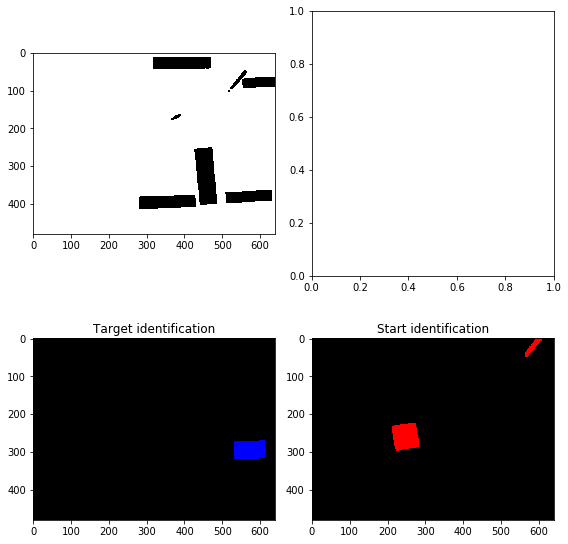

In [367]:
myMap, targetImage, startImage = get_img()
newMap, tstart, tgoal = get_map_img2(myMap, startImage, targetImage)

print(tstart)

fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0][0].imshow(myMap)

# ax[0][1].imshow(orientationImage)
# ax[0][1].set_title("Target identification")

ax[1][0].imshow(targetImage)
ax[1][0].set_title("Target identification")

ax[1][1].imshow(startImage)
ax[1][1].set_title("Start identification")

plt.tight_layout()
plt.show()

# Test Astar

Used to check if we can identify all the objective and find a path to the goal

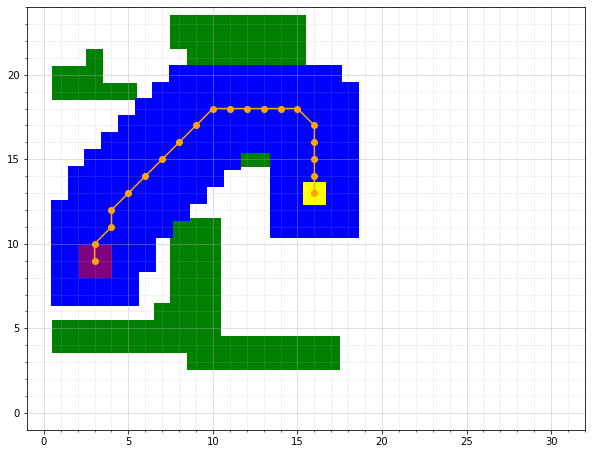

In [368]:
myMap, targetImage, startImage = get_img()
newMap, pos_est_img, goal_est_img = get_map_img2(myMap, startImage, targetImage)

if pos_est_img == -1 or goal_est_img == -1:
        raise Exception("can't identify all the objectives")

start = (round(pos_est_img[0]),round(pos_est_img[1]))
goal = (round(goal_est_img[0]),round(goal_est_img[1]))

h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
pathList, visitedNodes = A_Star(start, goal, h, coords, newMap, movement_type="8N")

path = np.array(pathList).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot()
ax_astar.imshow(newMap.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
#ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
for i in range(-thymioRadius+1, thymioRadius):
    for j in range(-thymioRadius+1, thymioRadius):
        ax_astar.scatter(path[0]+i, path[1]+j, marker="s", color = 'blue',s=3000);
        a=1
        
ax_astar.plot(path[0], path[1], marker="o", color = 'orange');
ax_astar.scatter(start[0], start[1], marker="s", color = 'yellow', s=500);
ax_astar.scatter(goal[0], goal[1], marker="s", color = 'purple', s=1000);


# Compute the vitesse in case per second

Used to compute the vitesse of thymio in case per second for our motor speed

In [323]:
myMap, targetImage, startImage = get_img()
newMap, tstart, tgoal = get_map_img2(myMap, startImage, targetImage)

print(tstart)

duration = 3

move_forward()
time.sleep(duration)
stop()
myMap, targetImage, startImage = get_img()
newMap, tfinish, tgoal = get_map_img2(myMap, startImage, targetImage)

print(tfinish)

V_case_per_second = np.linalg.norm((tfinish[0]-tstart[0], tfinish[1]-tstart[1]))/duration

print("vitesse: ",V_case_per_second)

[21.48070994862214, 9.854156936011211]
[17.719342135742416, 9.988070419272642]
vitesse:  1.2545836248097435


In [355]:
V_case_per_second =1.25

# Main loop

Our main code works as follow :

If all the objectives in the system are identified (i.e start position of Thymio, goal, obstacles), we compute Astar and then we pass to the robot the sequence of the next positions and the respective orders it has to perform in order to reach the target.

At every step we estimate the position and direction of the robot based on the odometry and we compare it to the ones given by the camera after completing the step. Basically we assume that our camera has a much lower error than the odometry measurements and so when the camera is available we rely completely on it, correcting the behaviour of the robot accordingly.
In the case of an unavailability of the camera, or some interference(i.e an hand in front of it), our odometry measurements are too weak to rely on, then we wait until we get the image again. One can notice that no correction is possible as we do not have any high fidelity measurement. Consequently, the strategy could fail if the odometry is highly perturbed by some disturbance (i.e wheel slipping, rough ground, mechanical failure).

If an unexpected obstacle appears, the robot will detect it with the proximity sensors and it will try to avoid it using a shortcut of the Pledge algorithm. We didn't implement the full Pledge algorithm as our interest is to avoid a simple obstacle and not escaping from a labyrinth.

We consider that the robot has avoided the obstacle if after the first turn it manages to follow the obstacle's wall and then turns to be oriented in the same direction as before entering the obstacle avoidance behaviour. When this condition is satisfied or if the robot hasn't found a way to avoid the obstacle(i.e no free path or incursion in map violation) we recompute Astar in order to make him catch the new optimal path to the goal.
The weakness of this choice is that if we lose the camera while the robot is performing the local obstacle avoidance, it will not success in calculating a new optimal path and the robot will be lost.

In [361]:
goalNotReached = True;
while goalNotReached:
    
    print("start")
    # get the first image
    
    first_pos == -1
    est_goal_img == -1
    count = 0
    
    while first_pos == -1 or est_goal_img == -1:
        myMap, targetImage, startImage = get_img()
        newMap, first_pos, est_goal_img = get_map_img2(myMap, startImage, targetImage)
        if count == 3:
            raise Exception("can't identify all the objectives")

    print("pos_est_img ", first_pos)
    
    # compute Astar and path
    start = (round(first_pos[0]),round(first_pos[1]))
    goal = (round(est_goal_img[0]),round(est_goal_img[1]))
    print("goal postion: ", est_goal_img)
    globalMap = newMap

    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    path, visitedNodes = A_Star(start, goal, h, coords, globalMap, movement_type="8N")
    myit = iter(path)
    thymioPos = next(myit)
    
    count = 0

    print("start at: ", start)

    # do a little step forward to compute the direction based on the previous position frome the camera and the new one
    duration = 0.2

    move_forward()
    time.sleep(duration)
    stop()
    myMap, targetImage, startImage = get_img()
    new_pos = get_thymio_pos_img(startImage, first_pos)
    
    if new_pos == -1:
        newMap, new_pos, est_goal_img2 = get_map_img2(myMap, startImage, targetImage)
        if new_pos ==-1:
            raise Exception("can't find thymio")
    
    last_pos = new_pos
    dir = get_angle(first_pos, new_pos)
    
    print("inital dir: ", dir)
    
    pos_est_filtered = new_pos
    
    #start aiming for the 2nd nodes
    nextPos = next(myit)
    
    # this function calibrate the direction of the thymio in order to go to the next cell
    time_travel = set_dir_cell(nextPos)

    print("time to travel: ", time_travel)
    
    myMap, targetImage, startImage = get_img()
    new_pos = get_thymio_pos_img(startImage, last_pos)
    if new_pos == -1:
        newMap, new_pos, est_goal_img2 = get_map_img2(myMap, startImage, targetImage)
        if new_pos ==-1:
            raise Exception("can't find thymio")
    
    # nitilizate the Kalman filter
    thymio.u = dir
    thymio.x[0] = new_pos[0]
    thymio.x[2] = new_pos[1]
    last_pos = new_pos
    
    thymio.predict()
    thymio.update(new_pos)
    
    # uses the kalman estimation as position filtered
    pos_est_filtered = (thymio.x[0], thymio.x[2])
    
    time_step = time.time()
    time_img = time_step
    
    move_forward()
    
    if thymioPos == goal:
        goalNotReached = False
    
    # main loop as long as the goal is not reach and the local obstacle can find the position of thymio
    while goalNotReached:

        threshold_obstacle = 3000
        if max(th["prox.horizontal"][1:4]) > threshold_obstacle:
            obstacle = True
        else:
            obstacle = False
        
        # look if we are in local or global navigation
        if obstacle:
            print("obstaaaaacle")
            go_left = True
            th.set_var_array("leds.top", [255, 0, 0])
            local_obstacle_avoidance()
            th.set_var_array("leds.top", [0, 0, 0])

            recomputeAstar = True
            break
        else:
            
            time_now = time.time()
            duration_last_step = time_now - time_step
            duration_last_img = time.time() - time_img
            
            # compute estimate position every 0.2 second or if the estimation based on the odometry has reach the next node
            if duration_last_img > 0.2 or duration_last_step > time_travel:
                
                time_img = time.time()

                myMap, targetImage, startImage = get_img()
                new_pos = get_thymio_pos_img(startImage, last_pos)
                
                # check if the goal has change every 10 estimation
                if count %10 == 9:
                    est_goal_img2 = get_goal_pos_img(targetImage, est_goal_img)
                
                    if est_goal_img2==-1 and not new_pos ==-1:
                        stop()
                        recomputeAstar = True
                        break
                
                # iterate the kalmann if we can see the thymio
                if new_pos == -1:
                    stop()
                    newMap, new_pos, est_goal_img2 = get_map_img2(myMap, startImage, targetImage)
                    while new_pos == -1:
                        myMap, targetImage, startImage = get_img()
                        newMap, new_pos, est_goal_img2 = get_map_img2(myMap, startImage, targetImage)
                    else:
                        thymio.predict()
                        thymio.update(new_pos)

                        pos_est_filtered = (thymio.x[0], thymio.x[2])

                        dir = get_angle(last_pos, new_pos)
                        thymio.u = dir

                        last_pos = new_pos
                
                else:
                    thymio.predict()
                    thymio.update(new_pos)

                    pos_est_filtered = (thymio.x[0], thymio.x[2])

                    dir = get_angle(last_pos, new_pos)
                    thymio.u = dir
                    
                    last_pos = new_pos
                    
#                     print("kalman pos: ", pos_est_filtered)
#                     print("camera pos: ", new_pos)
                    
                error = (pos_est_filtered[0]-nextPos[0],pos_est_filtered[1]-nextPos[1])
                
                # if we reach the node based on the order given, or if we are close based on the kalman estimation
                # we iterate for the next node
                if np.linalg.norm(error) < 1 or duration_last_step > time_travel:
                    nextPos = next(myit)
                    thymioPos = nextPos
                    
                    #if we think we reach the goal stop and break
                    if thymioPos == goal:
                        goalNotReached = False
                        stop()
                        myMap, targetImage, startImage = get_img()
                        pos_est_img = get_thymio_pos_img(startImage, pos_est_filtered)
                        print("final pos: ", pos_est_img)
                        print("goal est img: ", est_goal_img)
                        break;
                    
                    if nextPos == goal:
                        time_travel = set_dir_cell(est_goal_img)
                    else:
                        time_travel = set_dir_cell(nextPos)
                    thymio.u = dir
                    move_forward()
                    time_step = time.time()
                    
                count += 1

stop()
if goalNotReached:
    print("didn't reach destination")
else:
    print("destination reached")
    thymioWin()   

start
pos_est_img  [20.1241570327553, 6.330033718689787]
goal postion:  [4.98280095036959, 4.447241288278775]
start at:  (20, 6)
inital dir:  -11.077084358801384
147.1463793111125
time to travel:  2.2422407465588656
107.58045536933075
143.05222147184
101.3779168439156
79.13328473128709
80.51700741281539
120.55457684980216
138.52479657716677
111.6226210445793
92.69710642486919
84.97841274458955
95.82621179129532


KeyboardInterrupt: 

In [362]:
stop()